In [4]:
# !pip install --upgrade google-api-python-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 20.6 MB/s eta 0:00:00
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.84.0
    Uninstalling google-api-python-client-2.84.0:
      Successfully uninstalled google-api-python-client-2.84.0


In [5]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


Streaming platforms like YouTube, Netflix and Prime hate to see you go. They want to keep their users engaged in their content. Is there a way for these companies see what type of content you enjoy watching? Sometimes in order to influence our feed we explicitly search for "motivational videos/movies" etc but end up watching "stand up comedy" for hours. This could confusing for the model. Hence, models keep a keen eye on what content you watch repeatedly and for how long.

When platforms have the permission to access your front camera while using the app they will be able to understand if you're engaged in the content or not.

Let's build an image classifier to understand **HUMAN EMOTIONS**

We are classifying human emotions into
1. happy/smiling/enjoying
2. sad
3. angry
4. fearful
5. disgusted
6. yawning/distracted/uninterested

If an person displays any of the top 5 emotions while consuming content we can say that he/she is interested in the content and might continue to keep watching. Else, in the case where the consumer is uninterested they would potentially display any of the emotions on number 6.

First, we proceed by building our very own Deep Image Classifier. For this I refer to Nicolas Renotte's yet another popular tutorial: https://www.youtube.com/watch?v=jztwpsIzEGc&ab_channel=NicholasRenotte

Second: Let's use some existing models like
1. YOLOv8
2.
3.
4.
5.

Let's see which model performs the best.

Third: Let's biuld a model in PyTorch!

# Building our very own Deep Image Classifier

In [14]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
%cd '/content/drive/MyDrive/Projects/Emotion Detection'

/content/drive/MyDrive/Projects/Emotion Detection


In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!pip list

In [ ]:
!nvidia-smi

Sat Jul 29 22:18:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import os

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os

In [ ]:
# limit tensorflow using all of the  VRAM on the GPU
# by default when you load the data/tensorflow it will use all of
# the VRAM
# first line gives us all the gpus available
# second line tells tensorflow to keep gpu memory to a minimum or absolute requirement

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [ ]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!ls

data			 open.png    test3.png	test6.jpg
Emotion_Detection.ipynb  test1.png   test4.jpg	yolov8s-cls.pt
logs			 test2.jpeg  test5.png


# Remove dodgy images

In [ ]:
import cv2
import imghdr

In [ ]:
data_dir = 'data/train' # variable that points to our data directory

In [ ]:
image_exts = ['jpeg','jpg','png','bmp']

In [ ]:
image_exts[2]

'png'

In [ ]:
os.listdir(data_dir)

['uninterested', 'interested']

In [ ]:
os.listdir(os.path.join(data_dir, 'interested'))

['18a18a14a244a3cb33251965df5b7b2f--unique-faces-photography-p.jpg',
 'slurp_loading-eff1019358cea39bedf5fb3f86b99f01.gif',
 'slurploading_darkmode-0f3c762403f6ab2c4528aedf06f37849.gif',
 'stock-photo-portrait-of-an-angry-man-230627386.jpg',
 'royce-white-angry-face.jpg',
 'wife-believes-she-is-married-to-an-angry-man.jpg',
 'stock-photo-annoyance-171387467.jpg',
 'README.txt',
 'p_2x_940f4e19d966.png',
 'p_1x_bcbb8decf46e.png',
 'images (20).jpeg',
 'Angry-face.jpg',
 'angry_face_1170.jpg',
 'angry face.jpg',
 'GettyImages-172586047-1024x683.jpg',
 'depositphotos_39337815-stock-photo-angry-man.jpg',
 'depositphotos_20322059-stock-photo-angry-face-of-a-man.jpg',
 'angry-man-260nw-172757603.jpg',
 'headshot-angry-mad-face-asian-man-beard-mustache-headshot-an.jpg',
 'angry_faces.jpg',
 '284948494.jpg',
 '360_F_201011935_aurHVllAe1LmqVpHhlrh02kt3Y0MsdFI.jpg',
 '2680154-middle.png',
 '116999ecb25ac04c42cdac0a91c578439f-29-angry-face-2x-rsocial-.jpg',
 '59228086-emotion-fun-and-people-conce

In [ ]:
for image_class in os.listdir(data_dir):
  for image in os.listdir(os.path.join(data_dir, image_class)):
    image_path = os.path.join(data_dir, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exts:
        print("Image not in ext list {}".format(image_path))
        os.remove(image_path)
    except Exception as e:
      print('Issue with image {}'.format(image_path))

Image not in ext list data/train/uninterested/Boredom-732x549-thumbnail-1.jpg
Image not in ext list data/train/uninterested/bored-person-african-american-girl-260nw-625449857.jpg
Image not in ext list data/train/uninterested/bored-man-hand-on-his-260nw-611875787.jpg
Image not in ext list data/train/uninterested/114763133-very-bored-adult-man-with-beard-holding-hand-on-ch.jpg
Image not in ext list data/train/uninterested/153420947-young-woman-yawning-on-white-background-close-up-o.jpg
Image not in ext list data/train/uninterested/106846688-i-am-tired-of-everything-bored-man-boring-dull-ted.jpg
Image not in ext list data/train/uninterested/100138756-young-bored-man-in-a-studio-sitting-at-the-table.jpg
Image not in ext list data/train/uninterested/66230978.jpg
Image not in ext list data/train/uninterested/39141213-funny-face-young-man-bored-and-not-happy.jpg
Image not in ext list data/train/uninterested/34958450-lop-eared-teenager-with-a-bored-look-on-his-face-an.jpg
Image not in ext list

In [ ]:
sample_img = cv2.imread(os.path.join('data','train','interested','19eedf58c6a884eaec995907d3b4fe95.jpg'))

In [ ]:
type(sample_img)

numpy.ndarray

In [ ]:
sample_img.shape # height , width , number of color channels

(332, 500, 3)

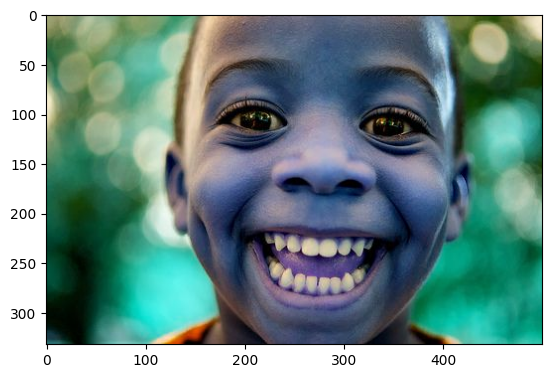

In [ ]:
plt.imshow(sample_img)

# The image is weird because openCV converts the image to BGR

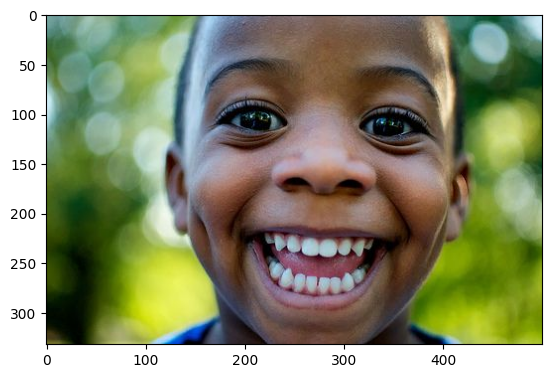

In [ ]:
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.show()

#Perfecto!

# Load data

In [ ]:
data = tf.keras.utils.image_dataset_from_directory('data/train')

Found 644 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
data_iterator

In [ ]:
batch = data_iterator.next()

In [ ]:
# images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [ ]:
batch[1]

array([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

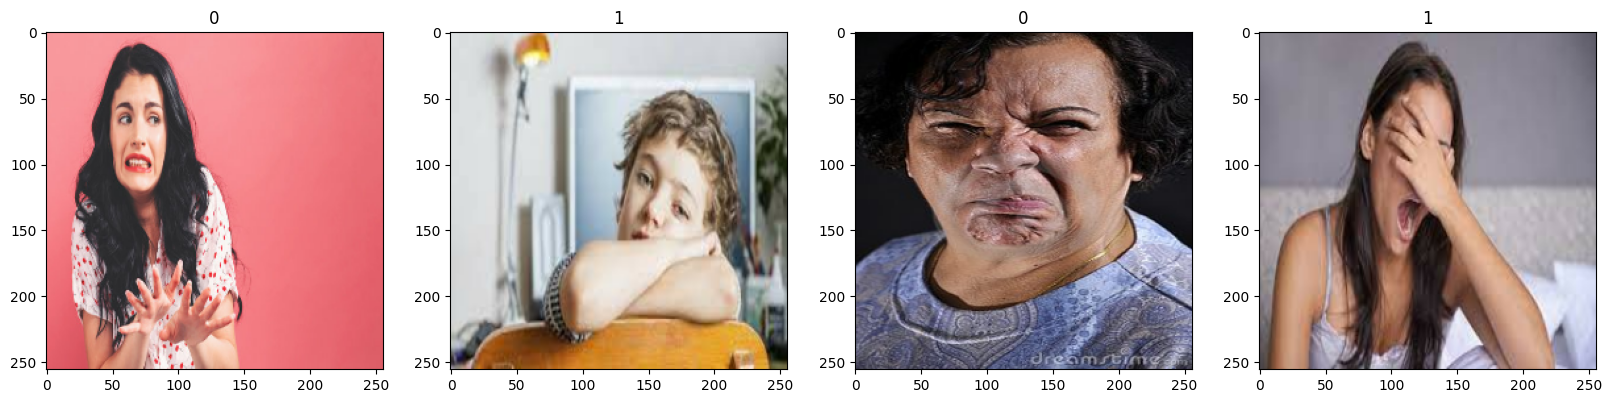

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

# Interested: 0
# Not Interested: 1

# Preprocess Data

1. Scale the Data

In [ ]:
data = data.map(lambda x,y: (x/255,y))

In [ ]:
scaled_iterator = data.as_numpy_iterator()

In [ ]:
batch = scaled_iterator.next()

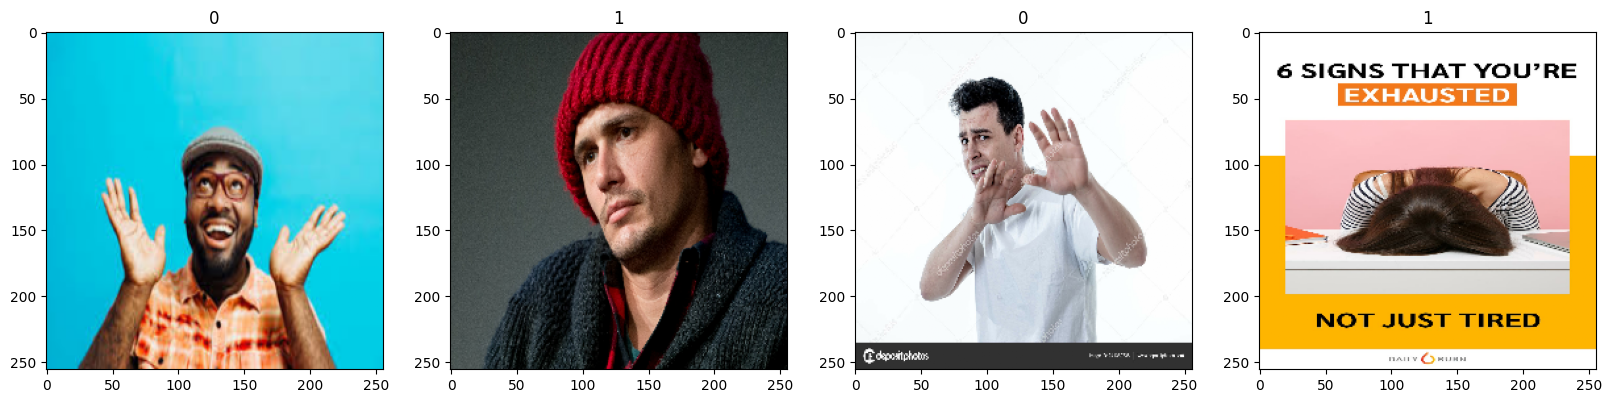

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

# split data

In [ ]:
len(data)

21

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [ ]:
print(train_size)
print(val_size)
print(test_size)

14
4
2


Therefore, train_size +val_size+test_size = len(data)

Since the data has already been shuffled

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [ ]:
len(train)

14

# Build the Deep Learning Model using the Keras Sequential API

Build Deep Learning Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [ ]:
# conv with 16 filters and filter is 3x3 size, a stride of 1
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# in keras fully connected layers are called Dense Layers
model.add(Dense(256,activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Train

In [ ]:
!pwd

/content/drive/MyDrive/Projects/Emotion Detection


In [ ]:
logdir = ('logs')

In [ ]:
!ls

data			 open.png    test3.png	test6.jpg
Emotion_Detection.ipynb  test1.png   test4.jpg	yolov8s-cls.pt
logs			 test2.jpeg  test5.png


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [ ]:
hist = model.fit(train, epochs = 40, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/40
14/14 [==============================] - 17s 659ms/step - loss: 0.8181 - accuracy: 0.5402 - val_loss: 0.6812 - val_accuracy: 0.6328
Epoch 2/40
14/14 [==============================] - 17s 1s/step - loss: 0.6721 - accuracy: 0.6027 - val_loss: 0.6474 - val_accuracy: 0.6406
Epoch 3/40
14/14 [==============================] - 13s 871ms/step - loss: 0.6865 - accuracy: 0.5357 - val_loss: 0.6678 - val_accuracy: 0.5625
Epoch 4/40
14/14 [==============================] - 13s 866ms/step - loss: 0.6544 - accuracy: 0.6607 - val_loss: 0.6229 - val_accuracy: 0.7109
Epoch 5/40
14/14 [==============================] - 13s 861ms/step - loss: 0.6212 - accuracy: 0.6875 - val_loss: 0.6870 - val_accuracy: 0.5703
Epoch 6/40
14/14 [==============================] - 16s 1s/step - loss: 0.5969 - accuracy: 0.6741 - val_loss: 0.5412 - val_accuracy: 0.7344
Epoch 7/40
14/14 [==============================] - 13s 860ms/step - loss: 0.5247 - accuracy: 0.7545 - val_loss: 0.5478 - val_accuracy: 0.6797
Epoch

# Plotting Performance

In [ ]:
hist

In [ ]:
hist.history

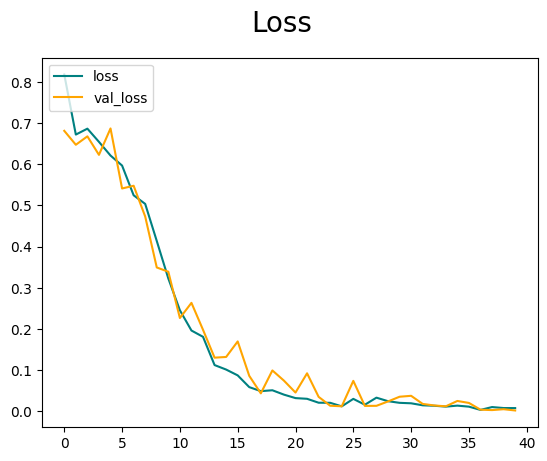

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

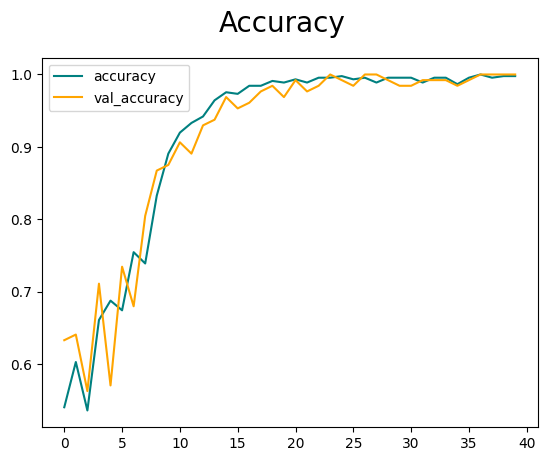

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

# Evaluation

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X, y = batch # X - images , y - true labels
  yhat = model.predict(X)
  precision.update_state(y, yhat)
  recall.update_state(y, yhat)
  accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 33ms/step


In [ ]:
print(f"Precision:{precision.result().numpy()}\nRecall: {recall.result().numpy()}\nAccuracy: {accuracy.result().numpy()}")

Precision:1.0
Recall: 0.9696969985961914
Accuracy: 0.984375


# Test

In [ ]:
!pwd

/content/drive/MyDrive/Projects/Emotion Detection


In [ ]:
%cd '/content/drive/MyDrive/Projects/Emotion Detection/data/test'

/content/drive/MyDrive/Projects/Emotion Detection/data/test


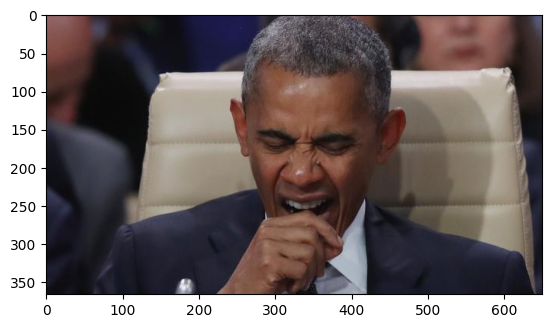

In [ ]:
img = cv2.imread('test1.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

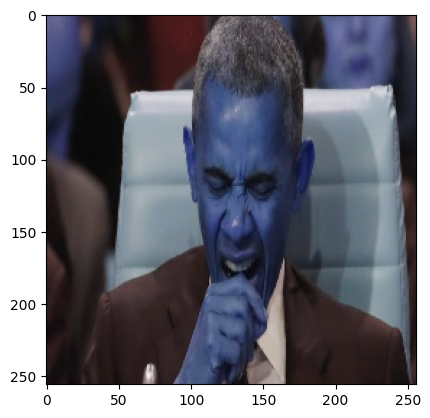

In [ ]:
# NN accepts images of the size 256x256
resize = tf.image.resize(img, (256,256))
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
resize.shape

TensorShape([256, 256, 3])

In [ ]:
# NN accepts a batch of images and not a single image, hence
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [ ]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 23ms/step


In [ ]:
yhat
if yhat > 0.5:
  print(f'Predicted class is Customer Not Interested ')
else:
  print(f'Predicted class is Customer Interested')

array([[0.9993992]], dtype=float32)

Interested : 0
Not Interested : 1

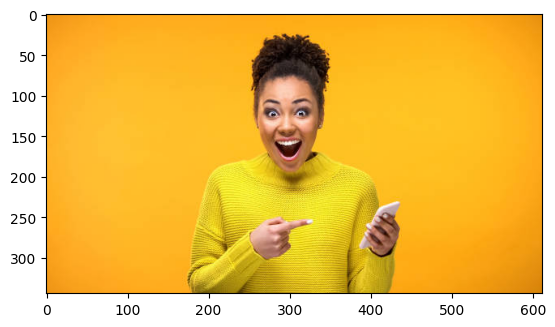

In [ ]:
img = cv2.imread('test2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

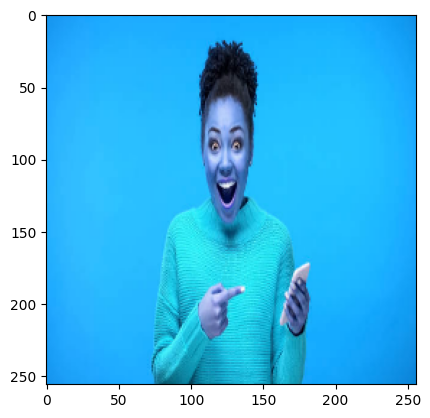

In [ ]:
# NN accepts images of the size 256x256
resize = tf.image.resize(img, (256,256))
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
# NN accepts a batch of images and not a single image, hence
np.expand_dims(resize, 0).shape

(1, 256, 256, 3)

In [ ]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 21ms/step


In [ ]:
yhat
if yhat > 0.5:
  print(f'Predicted class is Customer Not Interested ')
else:
  print(f'Predicted class is Customer Interested')

array([[0.00737771]], dtype=float32)

# Save the model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
!pwd

/content/drive/MyDrive/Projects/Emotion Detection/data/test


In [ ]:
%cd '/content/drive/MyDrive/Projects/Emotion Detection'

/content/drive/MyDrive/Projects/Emotion Detection


In [ ]:
model.save(os.path.join('models','customer_engagement_model'))

In [ ]:
new_model = load_model(os.path.join('models','customer_engagement_model'))

In [ ]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 77ms/step


In [ ]:
if yhatnew > 0.5:
  print(f'Predicted class is Customer Not Interested ')
else:
  print(f'Predicted class is Customer Interested')

Predicted class is Customer Interested


# YOLOv8 OBJECT CLASSIFICATION

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO

In [ ]:
model_8s = YOLO('yolov8s-cls.pt')

In [ ]:
model_8s.train(data = '/content/drive/MyDrive/Projects/Emotion Detection/data/', epochs = 10)

In [ ]:
# Validate the model
metrics = model_8s.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy
metrics.top5   # top5 accuracy

Ultralytics YOLOv8.0.144 🚀 Python-3.10.6 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-cls summary (fused): 73 layers, 5077762 parameters, 0 gradients
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
               classes   top1_acc   top5_acc: 100%|██████████| 1/1 [00:00<00:00, 16.13it/s]
                   all      0.333          1
Speed: 0.6ms preprocess, 13.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val


1.0

In [ ]:
!pwd

/content/drive/MyDrive/Projects/Emotion Detection


In [ ]:
source = '/content/drive/MyDrive/Projects/Emotion Detection/test_data'

In [ ]:
# Predict with the model
model_8s.predict(source, save=True, imgsz=320, conf=0.5)